<a href="https://colab.research.google.com/github/ishwarraja/SOAI-ERAV2/blob/main/S9/DP/modular/S9_Cutout_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

In [4]:
class Cifar10SearchDataset(datasets.CIFAR10):
    def __init__(self, root="~/data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, label

In [5]:
train = Cifar10SearchDataset(root='./data', train=True,download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:05<00:00, 29457704.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


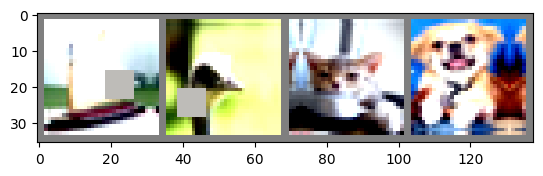

ship  bird  cat   dog  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3/1


        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5/1

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=32,
                kernel_size=(3,3),
                padding=2,
                stride=2,
                dilation=2,
                bias=False),
        ) # output_size = 16/7/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16/11/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16/15/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=32,
                      kernel_size=(3,3),
                      padding=2,
                      dilation=2,
                      stride=2,
                      bias=False),
        ) # output_size = 8/19/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 6/40/4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1/64

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]          18,432
           Conv2d-10           [-1, 64, 16, 16]          18,432
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.5306025743484497 Batch_id=97 Accuracy=34.52: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]



Test set: Average loss: 1.4692, Accuracy: 4644/10000 (46.44%)

EPOCH: 1


Loss=1.3664166927337646 Batch_id=97 Accuracy=50.27: 100%|██████████| 98/98 [00:15<00:00,  6.27it/s]



Test set: Average loss: 1.2022, Accuracy: 5625/10000 (56.25%)

EPOCH: 2


Loss=1.1003308296203613 Batch_id=97 Accuracy=57.56: 100%|██████████| 98/98 [00:15<00:00,  6.37it/s]



Test set: Average loss: 1.0609, Accuracy: 6162/10000 (61.62%)

EPOCH: 3


Loss=0.9022022485733032 Batch_id=97 Accuracy=62.04: 100%|██████████| 98/98 [00:16<00:00,  6.05it/s]



Test set: Average loss: 0.9520, Accuracy: 6614/10000 (66.14%)

EPOCH: 4


Loss=0.9412804841995239 Batch_id=97 Accuracy=64.94: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.8743, Accuracy: 6880/10000 (68.80%)

EPOCH: 5


Loss=0.9035664796829224 Batch_id=97 Accuracy=67.06: 100%|██████████| 98/98 [00:15<00:00,  6.34it/s]



Test set: Average loss: 0.8111, Accuracy: 7110/10000 (71.10%)

EPOCH: 6


Loss=0.8388769030570984 Batch_id=97 Accuracy=69.20: 100%|██████████| 98/98 [00:17<00:00,  5.56it/s]



Test set: Average loss: 0.8010, Accuracy: 7158/10000 (71.58%)

EPOCH: 7


Loss=0.8549939393997192 Batch_id=97 Accuracy=70.50: 100%|██████████| 98/98 [00:15<00:00,  6.34it/s]



Test set: Average loss: 0.7313, Accuracy: 7418/10000 (74.18%)

EPOCH: 8


Loss=0.8037294745445251 Batch_id=97 Accuracy=71.65: 100%|██████████| 98/98 [00:15<00:00,  6.33it/s]



Test set: Average loss: 0.7252, Accuracy: 7476/10000 (74.76%)

EPOCH: 9


Loss=0.6963337659835815 Batch_id=97 Accuracy=73.22: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]



Test set: Average loss: 0.7050, Accuracy: 7515/10000 (75.15%)

EPOCH: 10


Loss=0.6496350169181824 Batch_id=97 Accuracy=73.88: 100%|██████████| 98/98 [00:15<00:00,  6.22it/s]



Test set: Average loss: 0.6393, Accuracy: 7778/10000 (77.78%)

EPOCH: 11


Loss=0.7357432246208191 Batch_id=97 Accuracy=74.60: 100%|██████████| 98/98 [00:15<00:00,  6.29it/s]



Test set: Average loss: 0.6484, Accuracy: 7785/10000 (77.85%)

EPOCH: 12


Loss=0.6660345792770386 Batch_id=97 Accuracy=75.58: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s]



Test set: Average loss: 0.6421, Accuracy: 7780/10000 (77.80%)

EPOCH: 13


Loss=0.772645115852356 Batch_id=97 Accuracy=76.35: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]



Test set: Average loss: 0.6013, Accuracy: 7927/10000 (79.27%)

EPOCH: 14


Loss=0.6342002749443054 Batch_id=97 Accuracy=77.18: 100%|██████████| 98/98 [00:15<00:00,  6.33it/s]



Test set: Average loss: 0.5813, Accuracy: 8007/10000 (80.07%)

EPOCH: 15


Loss=0.6038535237312317 Batch_id=97 Accuracy=77.48: 100%|██████████| 98/98 [00:16<00:00,  6.01it/s]



Test set: Average loss: 0.5386, Accuracy: 8159/10000 (81.59%)

EPOCH: 16


Loss=0.7010630965232849 Batch_id=97 Accuracy=78.24: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.5477, Accuracy: 8128/10000 (81.28%)

EPOCH: 17


Loss=0.6838103532791138 Batch_id=97 Accuracy=78.55: 100%|██████████| 98/98 [00:15<00:00,  6.19it/s]



Test set: Average loss: 0.5565, Accuracy: 8089/10000 (80.89%)

EPOCH: 18


Loss=0.5948417782783508 Batch_id=97 Accuracy=79.39: 100%|██████████| 98/98 [00:16<00:00,  5.97it/s]



Test set: Average loss: 0.5330, Accuracy: 8175/10000 (81.75%)

EPOCH: 19


Loss=0.6692773699760437 Batch_id=97 Accuracy=79.48: 100%|██████████| 98/98 [00:15<00:00,  6.26it/s]



Test set: Average loss: 0.5137, Accuracy: 8181/10000 (81.81%)

EPOCH: 20


Loss=0.61407470703125 Batch_id=97 Accuracy=79.80: 100%|██████████| 98/98 [00:15<00:00,  6.21it/s]



Test set: Average loss: 0.4949, Accuracy: 8294/10000 (82.94%)

EPOCH: 21


Loss=0.6485224962234497 Batch_id=97 Accuracy=80.08: 100%|██████████| 98/98 [00:16<00:00,  5.98it/s]



Test set: Average loss: 0.5130, Accuracy: 8251/10000 (82.51%)

EPOCH: 22


Loss=0.5061438679695129 Batch_id=97 Accuracy=80.53: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.4918, Accuracy: 8319/10000 (83.19%)

EPOCH: 23


Loss=0.5787820816040039 Batch_id=97 Accuracy=80.80: 100%|██████████| 98/98 [00:15<00:00,  6.27it/s]



Test set: Average loss: 0.4933, Accuracy: 8317/10000 (83.17%)

EPOCH: 24


Loss=0.6253159642219543 Batch_id=97 Accuracy=81.11: 100%|██████████| 98/98 [00:16<00:00,  6.02it/s]



Test set: Average loss: 0.4984, Accuracy: 8274/10000 (82.74%)

EPOCH: 25


Loss=0.5613186955451965 Batch_id=97 Accuracy=81.22: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.4794, Accuracy: 8367/10000 (83.67%)

EPOCH: 26


Loss=0.4423721730709076 Batch_id=97 Accuracy=81.48: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.4800, Accuracy: 8356/10000 (83.56%)

EPOCH: 27


Loss=0.5200824737548828 Batch_id=97 Accuracy=81.63: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.4721, Accuracy: 8364/10000 (83.64%)

EPOCH: 28


Loss=0.5215268135070801 Batch_id=97 Accuracy=81.50: 100%|██████████| 98/98 [00:15<00:00,  6.29it/s]



Test set: Average loss: 0.4568, Accuracy: 8472/10000 (84.72%)

EPOCH: 29


Loss=0.4716106653213501 Batch_id=97 Accuracy=82.27: 100%|██████████| 98/98 [00:15<00:00,  6.37it/s]



Test set: Average loss: 0.4483, Accuracy: 8472/10000 (84.72%)

EPOCH: 30


Loss=0.525728702545166 Batch_id=97 Accuracy=82.41: 100%|██████████| 98/98 [00:15<00:00,  6.29it/s]



Test set: Average loss: 0.4400, Accuracy: 8505/10000 (85.05%)

EPOCH: 31


Loss=0.44732406735420227 Batch_id=97 Accuracy=82.93: 100%|██████████| 98/98 [00:15<00:00,  6.19it/s]



Test set: Average loss: 0.4306, Accuracy: 8544/10000 (85.44%)

EPOCH: 32


Loss=0.6036876440048218 Batch_id=97 Accuracy=82.83: 100%|██████████| 98/98 [00:15<00:00,  6.34it/s]



Test set: Average loss: 0.4417, Accuracy: 8502/10000 (85.02%)

EPOCH: 33


Loss=0.5056478977203369 Batch_id=97 Accuracy=82.97: 100%|██████████| 98/98 [00:15<00:00,  6.36it/s]



Test set: Average loss: 0.4591, Accuracy: 8458/10000 (84.58%)

EPOCH: 34


Loss=0.5190901756286621 Batch_id=97 Accuracy=83.17: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.4498, Accuracy: 8478/10000 (84.78%)

EPOCH: 35


Loss=0.5393794178962708 Batch_id=97 Accuracy=83.45: 100%|██████████| 98/98 [00:15<00:00,  6.28it/s]



Test set: Average loss: 0.4251, Accuracy: 8546/10000 (85.46%)

EPOCH: 36


Loss=0.5481693148612976 Batch_id=97 Accuracy=83.59: 100%|██████████| 98/98 [00:15<00:00,  6.37it/s]



Test set: Average loss: 0.4492, Accuracy: 8449/10000 (84.49%)

EPOCH: 37


Loss=0.4505653381347656 Batch_id=97 Accuracy=83.60: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]



Test set: Average loss: 0.4229, Accuracy: 8581/10000 (85.81%)

EPOCH: 38


Loss=0.45262837409973145 Batch_id=97 Accuracy=83.68: 100%|██████████| 98/98 [00:15<00:00,  6.34it/s]



Test set: Average loss: 0.4188, Accuracy: 8585/10000 (85.85%)

EPOCH: 39


Loss=0.4515673816204071 Batch_id=97 Accuracy=84.02: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]



Test set: Average loss: 0.4119, Accuracy: 8567/10000 (85.67%)

EPOCH: 40


Loss=0.4555342197418213 Batch_id=97 Accuracy=84.23: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.4179, Accuracy: 8602/10000 (86.02%)

EPOCH: 41


Loss=0.500921368598938 Batch_id=97 Accuracy=84.40: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s]



Test set: Average loss: 0.4222, Accuracy: 8572/10000 (85.72%)

EPOCH: 42


Loss=0.4668918251991272 Batch_id=97 Accuracy=84.42: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s]



Test set: Average loss: 0.4114, Accuracy: 8597/10000 (85.97%)

EPOCH: 43


Loss=0.4687202572822571 Batch_id=97 Accuracy=84.67: 100%|██████████| 98/98 [00:15<00:00,  6.29it/s]



Test set: Average loss: 0.4071, Accuracy: 8612/10000 (86.12%)

EPOCH: 44


Loss=0.4080903232097626 Batch_id=97 Accuracy=84.72: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.4032, Accuracy: 8625/10000 (86.25%)

EPOCH: 45


Loss=0.4184328317642212 Batch_id=97 Accuracy=84.72: 100%|██████████| 98/98 [00:15<00:00,  6.28it/s]



Test set: Average loss: 0.3954, Accuracy: 8663/10000 (86.63%)

EPOCH: 46


Loss=0.4788418412208557 Batch_id=97 Accuracy=84.89: 100%|██████████| 98/98 [00:15<00:00,  6.19it/s]



Test set: Average loss: 0.4100, Accuracy: 8606/10000 (86.06%)

EPOCH: 47


Loss=0.4403032660484314 Batch_id=97 Accuracy=85.15: 100%|██████████| 98/98 [00:15<00:00,  6.26it/s]



Test set: Average loss: 0.3974, Accuracy: 8660/10000 (86.60%)

EPOCH: 48


Loss=0.45939382910728455 Batch_id=97 Accuracy=85.09: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]



Test set: Average loss: 0.4229, Accuracy: 8589/10000 (85.89%)

EPOCH: 49


Loss=0.39419668912887573 Batch_id=97 Accuracy=85.15: 100%|██████████| 98/98 [00:15<00:00,  6.33it/s]



Test set: Average loss: 0.4073, Accuracy: 8603/10000 (86.03%)



In [12]:
# Count the Number of Receptive Field for the Model
# import torch
# import torch.nn as nn
# from model import Net

def get_receptive_field(model):
    receptive_field = 1
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            dilation = module.dilation[0]
            kernel_size = module.kernel_size[0]
            stride = module.stride[0]
            receptive_field = (receptive_field - 1) * stride + dilation * (kernel_size - 1) + 1
        elif isinstance(module, nn.MaxPool2d):
            kernel_size = module.kernel_size
            stride = module.stride
            receptive_field = (receptive_field - 1) * stride + kernel_size

    return receptive_field

# Create an instance of your model
model = Net()

# Calculate the receptive field
receptive_field_size = get_receptive_field(model)

# Check if the receptive field size is less than 44
if receptive_field_size < 44:
    print("The model has a receptive field size is less.",receptive_field_size)
else:
    print("The model has a receptive field size of 44 or more.")

The model has a receptive field size is less. 43


In [13]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2), bias=False)
  )
  (convblock4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3),

In [14]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 10
conv_layers
